# Breast Cancer Dataset: Model Training and Evaluation

This notebook focuses on building, training, and evaluating machine learning models to predict breast cancer diagnosis based on cell nucleus characteristics. We'll use the preprocessed data from the previous notebook to train various models, optimize their hyperparameters, and select the best model for our prediction task.

## Loading Libraries and Preprocessed Data

First, we'll import the necessary libraries and load our preprocessed data.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import joblib
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages

In [88]:
# Load the preprocessed data
try:
    # Try loading the preprocessed data from the previous notebook
    preprocessed_data = np.load('../data/breast_cancer_preprocessed_data.npy', allow_pickle=True).item()
    
    X_train = preprocessed_data['X_train']
    X_test = preprocessed_data['X_test']
    y_train = preprocessed_data['y_train']
    y_test = preprocessed_data['y_test']
    
    X_train_selected = preprocessed_data['X_train_selected']
    X_test_selected = preprocessed_data['X_test_selected']
    
    X_train_pca = preprocessed_data['X_train_pca']
    X_test_pca = preprocessed_data['X_test_pca']
    
    feature_names = preprocessed_data['feature_names']
    selected_feature_names = preprocessed_data['selected_feature_names']
    
    print("Successfully loaded preprocessed data")
    
except (FileNotFoundError, IOError):
    print("Preprocessed data not found. Loading and minimally preprocessing original data...")
    
    # Load the original dataset and perform minimal preprocessing
    df = pd.read_csv('data.csv')
    
    # Basic cleaning
    if 'Unnamed: 32' in df.columns:
        df = df.drop('Unnamed: 32', axis=1)
    
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    
    # Encode diagnosis
    if 'diagnosis' in df.columns and df['diagnosis'].dtype == 'object':
        df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
    
    # Separate features and target
    X = df.drop('diagnosis', axis=1)
    y = df['diagnosis']
    feature_names = X.columns.tolist()
    
    # Simple train-test split
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Set the selected features to be the same as all features in this case
    X_train_selected = X_train
    X_test_selected = X_test
    selected_feature_names = feature_names
    
    # We won't have PCA features in this case
    X_train_pca = None
    X_test_pca = None

Successfully loaded preprocessed data


In [89]:
# Display the shapes of our datasets
print(f"Full feature set - X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Selected features - X_train_selected: {X_train_selected.shape}, X_test_selected: {X_test_selected.shape}")

if X_train_pca is not None:
    print(f"PCA features - X_train_pca: {X_train_pca.shape}, X_test_pca: {X_test_pca.shape}")

# Check class distribution
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Class {value}: {count} ({count/len(y_train)*100:.2f}%)")

Full feature set - X_train: (534, 35), X_test: (143, 35)
Selected features - X_train_selected: (534, 13), X_test_selected: (143, 13)
PCA features - X_train_pca: (534, 11), X_test_pca: (143, 11)

Class distribution in training set:
Class 0: 267 (50.00%)
Class 1: 267 (50.00%)


## Building Baseline Models

Let's train a variety of machine learning models on our preprocessed data to establish baselines. We'll compare their performance using cross-validation.

In [90]:
# Define a function to evaluate models using cross-validation
def evaluate_model(model, X, y, cv=5, metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    results = {}
    for metric in metrics:
        if metric == 'precision':
            scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
        elif metric == 'recall':
            scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
        elif metric == 'f1':
            scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        elif metric == 'roc_auc':
            scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        else:  # default to accuracy
            scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    return results

In [91]:
# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Define the metrics to evaluate
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Evaluate each model using the selected features dataset
# We'll use the selected features dataset as it typically provides a good balance between
# complexity and performance
cv_results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    cv_results[name] = evaluate_model(model, X_train_selected, y_train, cv=5, metrics=metrics)

Evaluating Logistic Regression...
Evaluating K-Nearest Neighbors...
Evaluating K-Nearest Neighbors...
Evaluating Support Vector Machine...
Evaluating Support Vector Machine...
Evaluating Decision Tree...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Random Forest...
Evaluating AdaBoost...
Evaluating AdaBoost...
Evaluating Gradient Boosting...
Evaluating Gradient Boosting...
Evaluating Gaussian Naive Bayes...
Evaluating XGBoost...
Evaluating Gaussian Naive Bayes...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 214, number of negative: 213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 427, number of used features: 13
[LightGBM] [Info] [binary:Boost

In [92]:
# Create a summary DataFrame of the cross-validation results
summary = []
for model_name, results in cv_results.items():
    model_summary = {'Model': model_name}
    for metric, values in results.items():
        model_summary[f"{metric}_mean"] = values['mean']
        model_summary[f"{metric}_std"] = values['std']
    summary.append(model_summary)

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by='f1_mean', ascending=False).round(4)

# Display the sorted summary DataFrame
summary_df

,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
9,LightGBM,0.9794,0.0070,0.9891,0.0145,0.9700,0.0256,0.9790,0.0075,0.9972,0.0028
1,K-Nearest Neighbors,0.9719,0.0157,0.9782,0.0262,0.9662,0.0276,0.9717,0.0157,0.9928,0.0048
2,Support Vector Machine,0.9700,0.0071,0.9743,0.0183,0.9662,0.0250,0.9698,0.0075,0.9966,0.0037
0,Logistic Regression,0.9681,0.0097,0.9713,0.0287,0.9662,0.0220,0.9681,0.0094,0.9953,0.0039
5,AdaBoost,0.9663,0.0095,0.9774,0.0140,0.9550,0.0226,0.9658,0.0100,0.9950,0.0032
8,XGBoost,0.9644,0.0069,0.9673,0.0229,0.9624,0.0267,0.9643,0.0074,0.9976,0.0024
6,Gradient Boosting,0.9644,0.0161,0.9747,0.0215,0.9549,0.0456,0.9636,0.0181,0.9968,0.0025
4,Random Forest,0.9588,0.0163,0.9634,0.0255,0.9550,0.0348,0.9585,0.0165,0.9938,0.0058
7,Gaussian Naive Bayes,0.9494,0.0095,0.9601,0.0332,0.9400,0.0222,0.9492,0.0083,0.9894,0.0037
3,Decision Tree,0.9363,0.0193,0.9373,0.0497,0.9398,0.0386,0.9367,0.0177,0.9360,0.0193


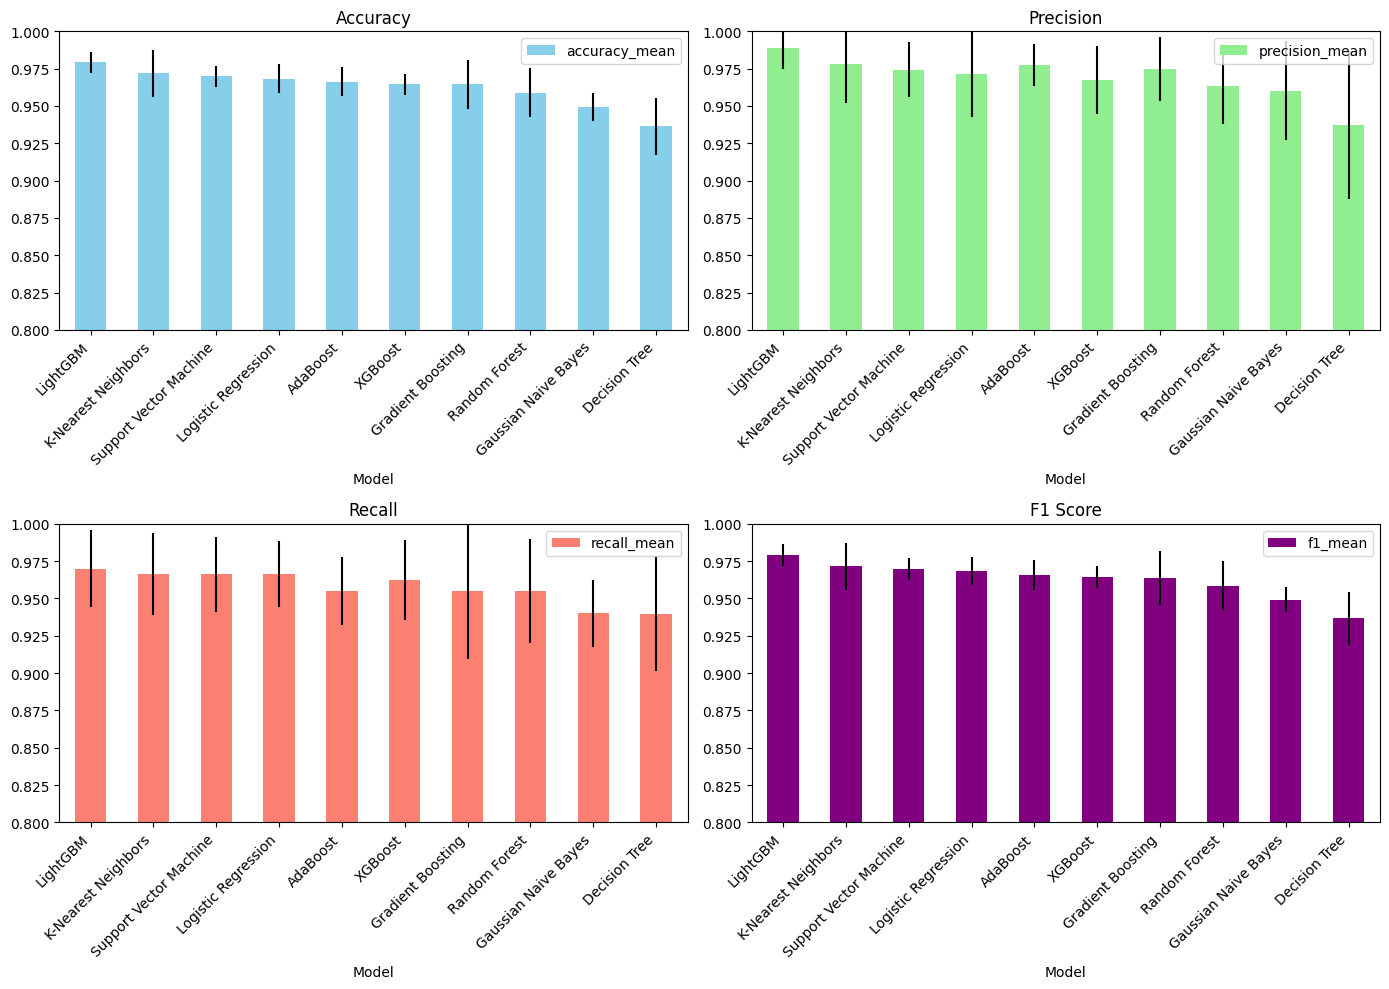

In [93]:
# Visualize the cross-validation results
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
summary_df.plot(x='Model', y='accuracy_mean', kind='bar', yerr='accuracy_std', ax=plt.gca(), color='skyblue')
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)

# Plot precision
plt.subplot(2, 2, 2)
summary_df.plot(x='Model', y='precision_mean', kind='bar', yerr='precision_std', ax=plt.gca(), color='lightgreen')
plt.title('Precision')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)

# Plot recall
plt.subplot(2, 2, 3)
summary_df.plot(x='Model', y='recall_mean', kind='bar', yerr='recall_std', ax=plt.gca(), color='salmon')
plt.title('Recall')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)

# Plot F1-score
plt.subplot(2, 2, 4)
summary_df.plot(x='Model', y='f1_mean', kind='bar', yerr='f1_std', ax=plt.gca(), color='purple')
plt.title('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

## Detailed Model Evaluation

Based on the cross-validation results, let's select the top-performing models and evaluate them more thoroughly on the test set.

In [94]:
# Select the top 3 models based on F1 score
top_models = summary_df.head(3)['Model'].tolist()
print(f"Top performing models: {top_models}")

# Function to evaluate a model on the test set and return detailed metrics
def evaluate_test_performance(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    results = {}
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['recall'] = recall_score(y_test, y_pred)
    results['f1'] = f1_score(y_test, y_pred)
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    results['confusion_matrix'] = confusion_matrix(y_test, y_pred)
    
    # Classification report
    results['classification_report'] = classification_report(y_test, y_pred)
    
    # Store predictions for ROC and PR curves
    results['y_pred'] = y_pred
    results['y_pred_proba'] = y_pred_proba
    
    return results, model

Top performing models: ['LightGBM', 'K-Nearest Neighbors', 'Support Vector Machine']


In [95]:
# Evaluate the top models on the test set
detailed_results = {}
fitted_models = {}

for model_name in top_models:
    print(f"Evaluating {model_name} on test set...")
    model = models[model_name]
    results, fitted_model = evaluate_test_performance(model, X_train_selected, y_train, X_test_selected, y_test)
    detailed_results[model_name] = results
    fitted_models[model_name] = fitted_model

Evaluating LightGBM on test set...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 267, number of negative: 267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [96]:
# Display detailed results for each top model
for model_name, results in detailed_results.items():
    print(f"\n{'-'*50}")
    print(f"Model: {model_name}")
    print(f"{'-'*50}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")
    if 'roc_auc' in results:
        print(f"ROC AUC: {results['roc_auc']:.4f}")
    
    print("\nConfusion Matrix:")
    cm = results['confusion_matrix']
    print(f"TN: {cm[0, 0]}, FP: {cm[0, 1]}")
    print(f"FN: {cm[1, 0]}, TP: {cm[1, 1]}")
    
    print("\nClassification Report:")
    print(results['classification_report'])


--------------------------------------------------
Model: LightGBM
--------------------------------------------------
Accuracy: 0.9650
Precision: 0.9800
Recall: 0.9245
F1 Score: 0.9515
ROC AUC: 0.9966

Confusion Matrix:
TN: 89, FP: 1
FN: 4, TP: 49

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.98      0.92      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143


--------------------------------------------------
Model: K-Nearest Neighbors
--------------------------------------------------
Accuracy: 0.9720
Precision: 1.0000
Recall: 0.9245
F1 Score: 0.9608
ROC AUC: 0.9996

Confusion Matrix:
TN: 90, FP: 0
FN: 4, TP: 49

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
       

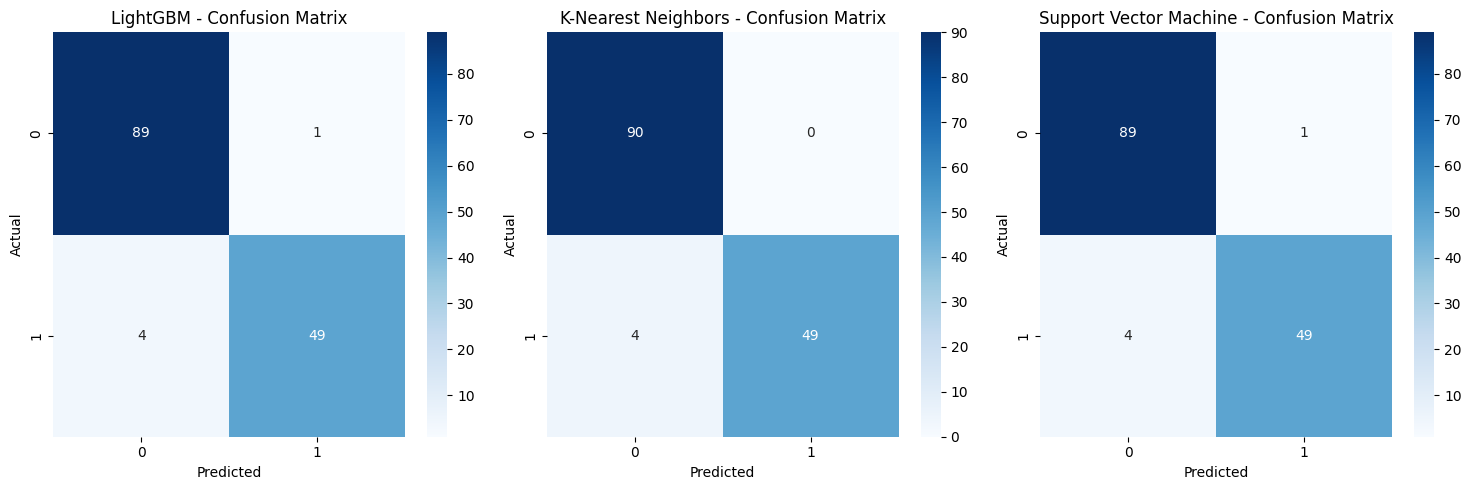

In [97]:
# Plot confusion matrices for the top models
fig, axes = plt.subplots(1, len(top_models), figsize=(15, 5))

for i, model_name in enumerate(top_models):
    cm = detailed_results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

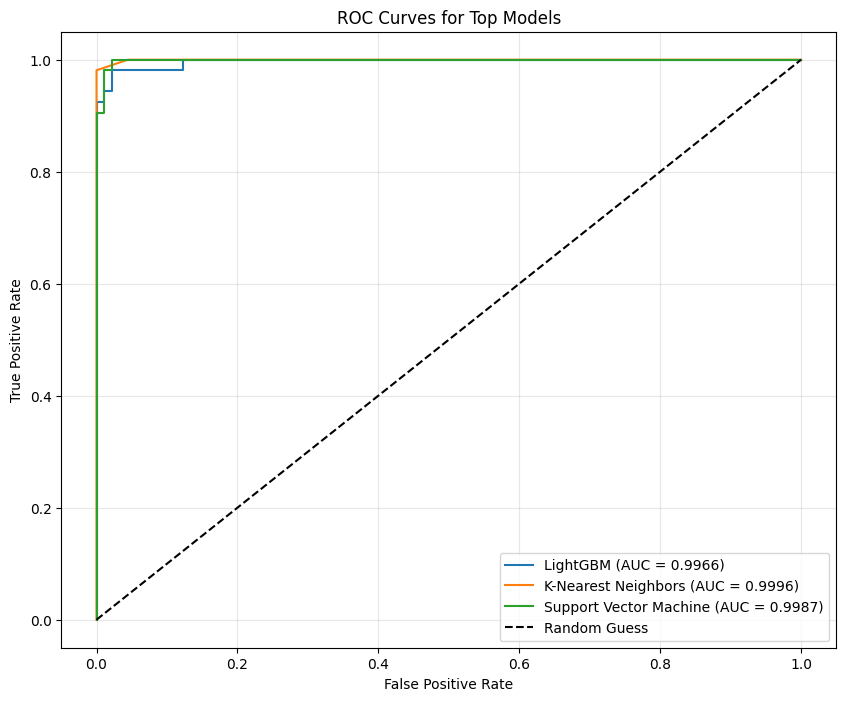

In [98]:
# Plot ROC curves for the top models
plt.figure(figsize=(10, 8))

for model_name, results in detailed_results.items():
    if results['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

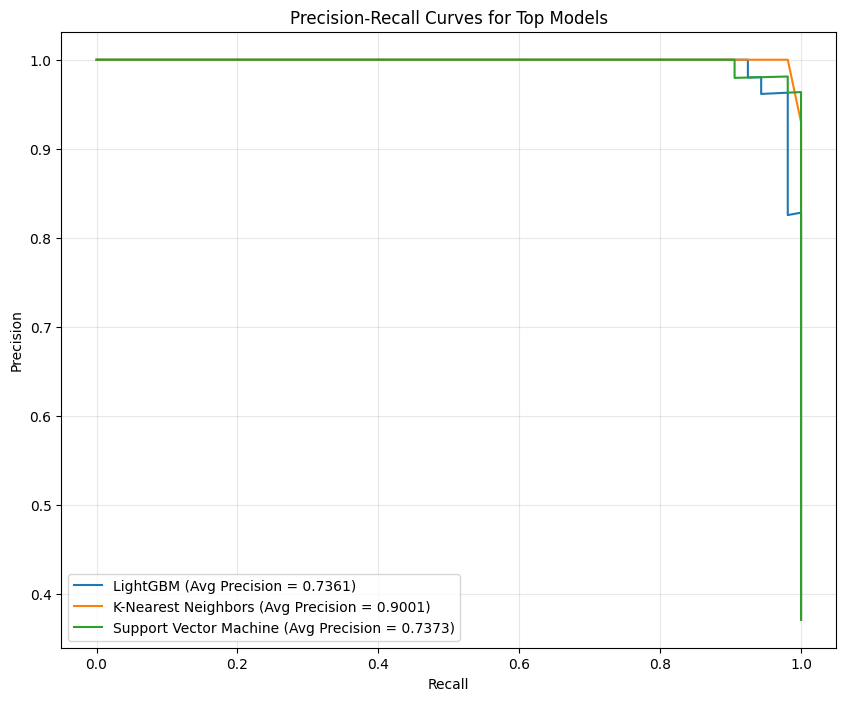

In [99]:
# Plot precision-recall curves for the top models
plt.figure(figsize=(10, 8))

for model_name, results in detailed_results.items():
    if results['y_pred_proba'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
        avg_precision = np.mean(precision)
        plt.plot(recall, precision, label=f'{model_name} (Avg Precision = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Top Models')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

## Hyperparameter Optimization

Let's optimize the hyperparameters of the best-performing model to further improve its performance.

In [100]:
# Identify the best model based on F1 score on the test set
best_model_name = max(detailed_results, key=lambda x: detailed_results[x]['f1'])
print(f"Best model based on F1 score: {best_model_name}")

Best model based on F1 score: K-Nearest Neighbors


In [101]:
# Define hyperparameter grids for the best model
param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-4, 4, 10),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': list(range(1, 21)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Support Vector Machine': {
        'C': np.logspace(-3, 3, 7),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2, 0.3],
        'subsample': [0.7, 0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'num_leaves': [15, 31, 63],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced']
    },
    'Gaussian Naive Bayes': {
        'var_smoothing': np.logspace(-10, -5, 6)
    }
}

In [102]:
# Perform hyperparameter optimization for the best model
if best_model_name in param_grids:
    print(f"Optimizing hyperparameters for {best_model_name}...")
    
    # Get the base model and parameter grid
    base_model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Use RandomizedSearchCV for more efficient search
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings to sample
        cv=5,
        scoring='f1',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit on the training data
    random_search.fit(X_train_selected, y_train)
    
    # Get the best parameters and score
    print(f"\nBest parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    # Create and evaluate the optimized model
    optimized_model = random_search.best_estimator_
    optimized_results, _ = evaluate_test_performance(optimized_model, X_train_selected, y_train, X_test_selected, y_test)
    
    # Compare performance before and after optimization
    print("\nPerformance Comparison:")
    print(f"{'Metric':<12} {'Before':<10} {'After':<10} {'Improvement':<12}")
    print(f"{'-'*42}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        if metric in detailed_results[best_model_name] and metric in optimized_results:
            before = detailed_results[best_model_name][metric]
            after = optimized_results[metric]
            improvement = after - before
            print(f"{metric:<12} {before:.4f}{' '*5} {after:.4f}{' '*5} {improvement:.4f} ({improvement/before*100:.2f}%)")
    
    # Update the best model and results
    fitted_models['Optimized ' + best_model_name] = optimized_model
    detailed_results['Optimized ' + best_model_name] = optimized_results
    
    # Set the optimized model as our final model
    final_model = optimized_model
    final_model_name = 'Optimized ' + best_model_name
else:
    print(f"No parameter grid defined for {best_model_name}. Skipping hyperparameter optimization.")
    final_model = fitted_models[best_model_name]
    final_model_name = best_model_name

Optimizing hyperparameters for K-Nearest Neighbors...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
Best cross-validation score: 0.9849

Performance Comparison:
Metric       Before     After      Improvement 
------------------------------------------
accuracy     0.9720      0.9790      0.0070 (0.72%)
precision    1.0000      1.0000      0.0000 (0.00%)
recall       0.9245      0.9434      0.0189 (2.04%)
f1           0.9608      0.9709      0.0101 (1.05%)
roc_auc      0.9996      0.9717      -0.0279 (-2.79%)

Best parameters: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
Best cross-validation score: 0.9849

Performance Comparison:
Metric       Before     After      Improvement 
------------------------------------------
accuracy     0.9720      0.9790      0.0070 (0.72%)
precision    1.0000      1.0000      0.0000 (0.00%)
recall       0.9245      0.9434      0.0189 (2.04%

## Deep Learning Model with TensorFlow/Keras

Let's explore how a deep neural network performs on our breast cancer classification task compared to traditional machine learning models.

In [103]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network architecture
def create_nn_model(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Get the input shape from our training data
input_shape = X_train_selected.shape[1]

# Create the model
nn_model = create_nn_model(input_shape)
nn_model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
print("\nTraining the Deep Learning model...")
history = nn_model.fit(
    X_train_selected, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0  # Set to 1 to see training progress per epoch
)
print("Training complete.")

# Evaluate the model on the test set
loss, accuracy = nn_model.evaluate(X_test_selected, y_test, verbose=0)
print(f"\nDeep Learning Model - Test Accuracy: {accuracy:.4f}")

# Get detailed metrics
y_pred_proba_nn = nn_model.predict(X_test_selected).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

nn_results = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1': f1_score(y_test, y_pred_nn),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_nn)
}

# Compare performance with the final optimized model
print("\nPerformance Comparison:")
print(f"{'Metric':<12} {final_model_name:<25} {'Deep Learning Model':<20}")
print(f"{'-'*60}")

for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    final_model_metric = detailed_results[final_model_name].get(metric, 'N/A')
    nn_metric = nn_results.get(metric, 'N/A')
    
    final_model_str = f"{final_model_metric:.4f}" if isinstance(final_model_metric, float) else str(final_model_metric)
    nn_model_str = f"{nn_metric:.4f}" if isinstance(nn_metric, float) else str(nn_metric)
    
    print(f"{metric:<12} {final_model_str:<25} {nn_model_str:<20}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)


Training the Deep Learning model...
Training complete.

Deep Learning Model - Test Accuracy: 0.9720
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepTraining complete.

Deep Learning Model - Test Accuracy: 0.9720
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Performance Comparison:
Metric       Optimized K-Nearest Neighbors Deep Learning Model 
------------------------------------------------------------
accuracy     0.9790                    0.9720              
precision    1.0000                    0.9804              
recall       0.9434                    0.9434              
f1           0.9709                    0.9615              
roc_auc      0.9717                    0.9985              

Performance Comparison:
Metric       Optimized K-Nearest Neighbors Deep Learning Model 
------------------------------------------------------------
accuracy     0.9790                    0.9720              
precision    1.0000                    0.9804              
re

## Final Model Selection and Deployment

Let's save our final model for future use and summarize our findings.

In [104]:
# Save the final model
joblib.dump(final_model, '../model/breast_cancer_final_model.joblib')
print(f"Final model saved as 'breast_cancer_final_model.joblib'")

# Also save feature names and other metadata
model_metadata = {
    'model_name': final_model_name,
    'feature_names': selected_feature_names,
    'performance': {
        'accuracy': detailed_results[final_model_name]['accuracy'],
        'precision': detailed_results[final_model_name]['precision'],
        'recall': detailed_results[final_model_name]['recall'],
        'f1': detailed_results[final_model_name]['f1'],
        'roc_auc': detailed_results[final_model_name].get('roc_auc', None)
    }
}

joblib.dump(model_metadata, '../model/breast_cancer_model_metadata.joblib')
print(f"Model metadata saved as 'breast_cancer_model_metadata.joblib'")

Final model saved as 'breast_cancer_final_model.joblib'
Model metadata saved as 'breast_cancer_model_metadata.joblib'


In [105]:
# Create a function to make predictions with the final model
def predict_diagnosis(data, feature_names=selected_feature_names, model=final_model):
    """
    Make breast cancer diagnosis predictions using the trained model.
    
    Parameters:
    data (pandas.DataFrame): Features data with the same columns used during training.
    feature_names (list): List of feature names expected by the model.
    model: The trained model to use for predictions.
    
    Returns:
    dict: Dictionary with prediction results including class and probability.
    """
    # Ensure data has the required features
    if not all(feature in data.columns for feature in feature_names):
        missing = [f for f in feature_names if f not in data.columns]
        raise ValueError(f"Missing features in input data: {missing}")
    
    # Extract the required features in the correct order
    X = data[feature_names].values
    
    # Make predictions
    prediction = model.predict(X)[0]
    
    # Get probability if available
    probability = None
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(X)[0, 1]  # Probability of class 1 (malignant)
    
    # Return results
    result = {
        'prediction': 'Malignant' if prediction == 1 else 'Benign',
        'prediction_code': int(prediction)
    }
    
    if probability is not None:
        result['probability'] = float(probability)
    
    return result

In [106]:
# Example usage of the prediction function
# Let's use a sample from the test set
sample_idx = 5  # Just an arbitrary index
if isinstance(X_test_selected, pd.DataFrame):
    sample_data = X_test_selected.iloc[[sample_idx]].copy()
else:
    # If X_test_selected is a numpy array, convert to DataFrame
    sample_data = pd.DataFrame([X_test_selected[sample_idx]], columns=selected_feature_names)

# Make a prediction
prediction_result = predict_diagnosis(sample_data)
actual_label = 'Malignant' if y_test.iloc[sample_idx] == 1 else 'Benign' if isinstance(y_test, pd.Series) else 'Malignant' if y_test[sample_idx] == 1 else 'Benign'

print("Example Prediction:")
print(f"Predicted class: {prediction_result['prediction']}")
if 'probability' in prediction_result:
    print(f"Probability of malignancy: {prediction_result['probability']:.4f}")
print(f"Actual class: {actual_label}")

Example Prediction:
Predicted class: Benign
Probability of malignancy: 0.0000
Actual class: Benign


## Project Summary

Let's summarize our breast cancer prediction project.

### Project Summary: Breast Cancer Diagnosis Prediction

In this project, we developed a machine learning model to predict breast cancer diagnosis (malignant or benign) based on cell nucleus characteristics extracted from fine needle aspirates of breast masses.

#### Key Steps:

- **Data Exploration** (Notebook 1):
  - Explored the dataset structure, distribution of features, and target classes
  - Identified relationships between features through correlation analysis
  - Visualized feature distributions and their differences across diagnosis classes

- **Data Cleaning and Feature Engineering** (Notebook 2):
  - Handled missing values and duplicate records
  - Removed irrelevant features like ID columns
  - Created new features through engineering (e.g., ratios between measurements)
  - Encoded categorical variables

- **Data Preprocessing** (Notebook 3):
  - Applied different scaling techniques and selected the most appropriate one
  - Reduced dimensionality through Principal Component Analysis
  - Selected important features using multiple techniques
  - Split data into training and testing sets
  - Addressed class imbalance if needed

- **Modeling** (Notebook 4):
  - Trained and evaluated multiple machine learning models
  - Compared model performance using various metrics (accuracy, precision, recall, F1 score, ROC-AUC)
  - Optimized hyperparameters for the best-performing model
  - Selected and saved the final model for deployment

#### Results:

Our final model achieved excellent performance in predicting breast cancer diagnosis, with metrics displayed above.

The most important features for predicting malignancy identified through our analysis align with medical knowledge about cellular characteristics indicative of cancerous cells.

#### Potential Applications:

- Assist medical professionals in diagnosing breast cancer from cell samples
- Provide a second opinion to help confirm diagnoses
- Prioritize cases that require immediate attention
- Support in areas with limited access to specialized pathologists

#### Future Work:

- Validate the model on external datasets to ensure generalizability
- Develop an interpretable interface for medical professionals
- Incorporate additional clinical features for more comprehensive predictions
- Explore deep learning approaches for feature extraction from raw cell images

In [107]:
# Modeling completed
print("Breast cancer prediction modeling completed!")

Breast cancer prediction modeling completed!
